# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

We want to predict the salary of a professional based on the data we are given. The data gives us information of the individual's jobID, companyID, the type of job, degree, major, industry (ALL categorical features) and years of experience and miles from Metropolis (numerical features).

In [148]:
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import xgboost as xg
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn import ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
#etc
warnings.simplefilter(action='ignore', category=FutureWarning)
#your info here
__author__ = "Thu Nguyen"
__email__ = "thumn6@uci.edu"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [102]:
#load the data into a Pandas dataframe
features = pd.read_csv("./data/train_features.csv")
salaries = pd.read_csv("./data/train_salaries.csv")
print(features.shape)
features.head()


(1000000, 8)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [103]:
salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


### ---- 3 Clean the data ----

In [104]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
# Making a list of missing value types

missing_values = ["n/a", "na", "--"]
features = pd.read_csv("./data/train_features.csv", na_values=missing_values);
salaries = pd.read_csv("./data/train_salaries.csv", na_values=missing_values);


In [105]:
# Summary of any missing values
print (features.isnull().sum())
# Check to see if there is any missing values
print (features.isnull().values.any())
# Total number of missing values
print (features.isnull().sum().sum())

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64
False
0


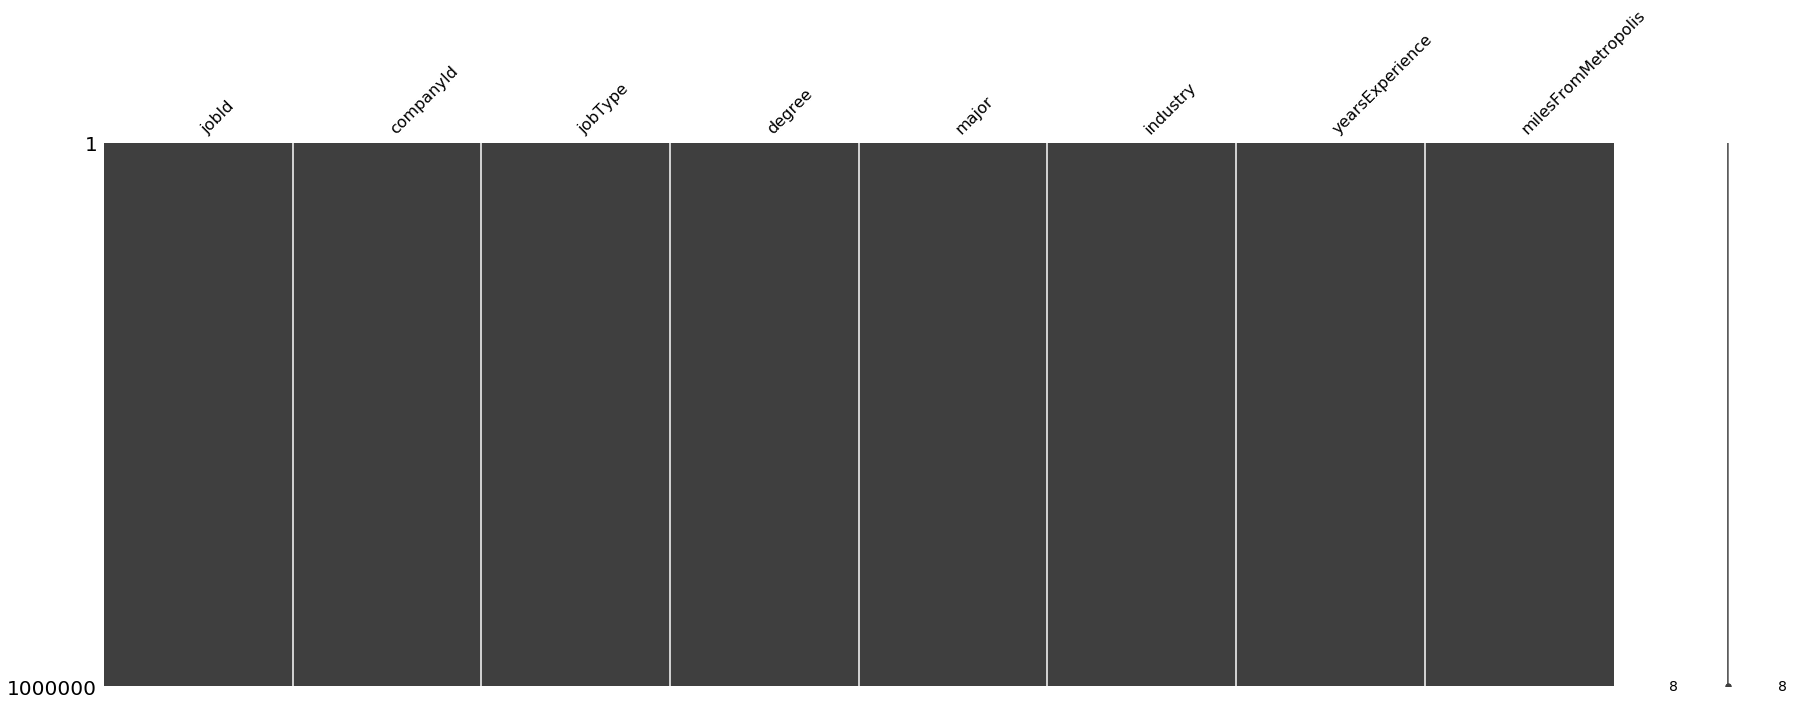

In [106]:
import missingno as msno
msno.matrix(features, figsize=(30,10))

### ---- 4 Explore the data (EDA) ----

In [107]:
#summarize each feature variable
print(pd.DataFrame.describe(features['yearsExperience']))
print(pd.DataFrame.describe(features['milesFromMetropolis']))
#summarize the target variable
print(pd.DataFrame.describe(salaries['salary']))
#look for correlation between each feature and the target

#look for correlation between features

count    1000000.000000
mean          11.992386
std            7.212391
min            0.000000
25%            6.000000
50%           12.000000
75%           18.000000
max           24.000000
Name: yearsExperience, dtype: float64
count    1000000.000000
mean          49.529260
std           28.877733
min            0.000000
25%           25.000000
50%           50.000000
75%           75.000000
max           99.000000
Name: milesFromMetropolis, dtype: float64
count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64


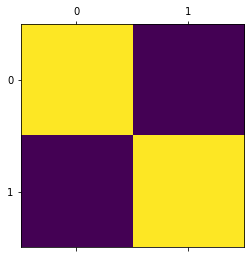

In [108]:
plt.matshow(features.corr())
plt.show()

In [109]:
print(features['jobType'].unique())

['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']


In [110]:
replace_map = {'degree': {'NONE': 0, 'HIGH_SCHOOL':1, 'BACHELORS':2,'MASTERS':3,'DOCTORAL':4}
               , 'jobType': {'JANITOR' : 1, 'JUNIOR':2, 'SENIOR':3, 'MANAGER':4, 'CEO':7, 
                'CFO':5, 'CTO':5, 'VICE_PRESIDENT':4},
              'major' : {'NONE':0, 'BUSINESS':2, 'BIOLOGY':2, 'PHYSICS':1, 'COMPSCI':3,
                        'MATH':2, 'CHEMISTRY':2, 'LITERATURE':1, 'ENGINEERING':3}}

In [111]:
print(features['degree'].unique())

['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']


In [112]:
print(features['major'].unique())

['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']


In [113]:
print(features['industry'].unique())

['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


In [114]:
features = features.replace(replace_map)

In [153]:
features.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,5,3,2,3,10,83
1,7,1,0,6,3,73
2,4,4,1,3,10,38
3,4,4,2,0,8,17
4,4,2,1,2,8,16


### Look for outliers

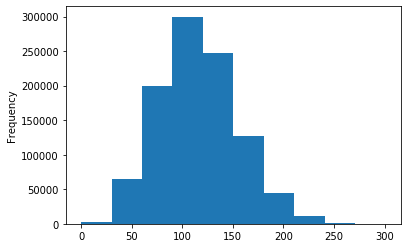

In [116]:
salaries.salary.plot.hist()

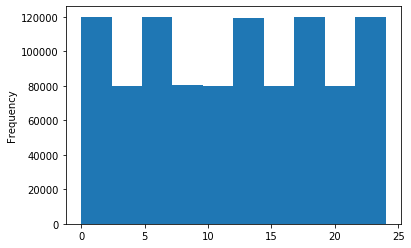

In [117]:
features.yearsExperience.plot.hist()

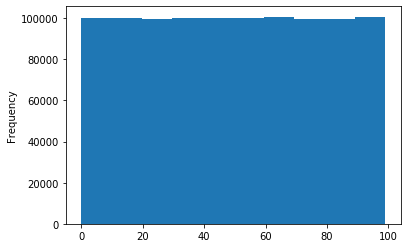

In [118]:
features.milesFromMetropolis.plot.hist()

### ---- 5 Establish a baseline ----

In [119]:
#select a reasonable metric (MSE in this case)
from sklearn.metrics import mean_squared_error
#create an extremely simple model and measure its efficacy
from sklearn.linear_model import LinearRegression

def baselineModel(train_features, train_salaries):
    
    industry_salary = pd.merge(train_features,train_salaries);
    industry_vs_salary = industry_salary.groupby(['industry']).mean();
    return industry_vs_salary;


#e.g. use "average salary" for each industry as your model and then measure MSE


#during 5-fold cross-validation




#### 5 fold cross validation

In [120]:
kf = KFold(n_splits=5);

mse_list_baseline = [];
index = kf.split(features);
for train_index, test_index in index:
    print("TRAIN:", train_index, "TEST:", test_index);
    train_features, test_features = features.iloc[train_index], features.iloc[test_index]
    train_salary, test_salary = salaries.iloc[train_index], salaries.iloc[test_index]
    model = baselineModel(train_features, train_salary);
    predicted_salary = pd.merge(test_features, model, on ='industry');
    mse_list_baseline.append(mean_squared_error(test_salary['salary'], predicted_salary['salary']))

TRAIN: [200000 200001 200002 ... 999997 999998 999999] TEST: [     0      1      2 ... 199997 199998 199999]
TRAIN: [     0      1      2 ... 999997 999998 999999] TEST: [200000 200001 200002 ... 399997 399998 399999]
TRAIN: [     0      1      2 ... 999997 999998 999999] TEST: [400000 400001 400002 ... 599997 599998 599999]
TRAIN: [     0      1      2 ... 999997 999998 999999] TEST: [600000 600001 600002 ... 799997 799998 799999]
TRAIN: [     0      1      2 ... 799997 799998 799999] TEST: [800000 800001 800002 ... 999997 999998 999999]


In [121]:
print("MSE", np.array(mse_list_baseline).mean())

MSE 1630.8646405439122


### ---- 6 Hypothesize solution ----

#### Drop columns that might be irrelevant to salaries, like jobID and companyID

In [122]:
features = features.drop(columns=['jobId', 'companyId'])

In [123]:
features.shape

(1000000, 6)

In [156]:
start = 0; end = 20; value = 1;
for i in range(5):
    
    features['milesFromMetropolis'] = np.where(features['milesFromMetropolis'].between(start,end), value, features['milesFromMetropolis']);
    value = value + 1;
    start = start + 20;
    end = end + 20;


In [157]:
features.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,5,3,2,3,10,5
1,7,1,0,6,3,4
2,4,4,1,3,10,2
3,4,4,2,0,8,1
4,4,2,1,2,8,1


#### Convert the categorical features into numerical

In [124]:
cat_features = ['industry'];
for cat in cat_features:
    features[cat] = preprocessing.LabelEncoder().fit_transform(features[cat])




In [125]:
features.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,5,3,2,3,10,83
1,7,1,0,6,3,73
2,4,4,1,3,10,38
3,4,4,2,0,8,17
4,4,2,1,2,8,16


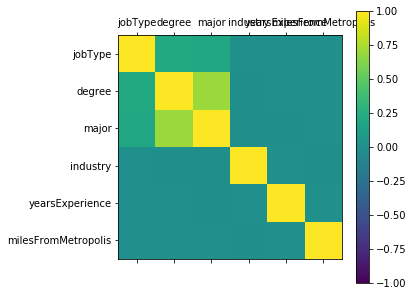

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobType,1.000000,0.215402,0.196572,0.000792,0.000966,0.000059
degree,0.215402,1.000000,0.700773,-0.001086,0.000219,0.002106
major,0.196572,0.700773,1.000000,-0.001029,-0.000308,0.001923
industry,0.000792,-0.001086,-0.001029,1.000000,0.000263,-0.000741
yearsExperience,0.000966,0.000219,-0.000308,0.000263,1.000000,0.000678
milesFromMetropolis,0.000059,0.002106,0.001923,-0.000741,0.000678,1.000000


In [158]:
correlations = features.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(features)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

In [127]:
def cross_val(model, f, s):
    kf = KFold(n_splits=5);
    mse_list = [];
    for train_index, test_index in kf.split(f):
    
        train_features, test_features = f.iloc[train_index], f.iloc[test_index]
        train_salary, test_salary = s.iloc[train_index], s.iloc[test_index];
    
        model.fit(train_features, train_salary['salary'])
    
    
   
        mse_list.append(mean_squared_error(test_salary['salary'], model.predict(test_features)));
    print("MSE: %.4f" % np.array(mse_list).mean())

### Linear Regression

In [159]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 
linearL = linear_model.LinearRegression()
cross_val(linearL, features, salaries)
#590 ->530

MSE: 535.4011


### Decision Tree

In [160]:
dtree = DecisionTreeRegressor(random_state=0)
# mse 674

In [161]:
cross_val(dtree, features, salaries)

MSE: 418.4831


### Random Forest

In [162]:
random_forest = RandomForestRegressor(max_depth=6, random_state=0)
# mse 565 -> 555

In [163]:
cross_val(random_forest, features, salaries)

MSE: 560.3277


### XGBoost

In [164]:
xgb = XGBRegressor(silent=1);
cross_val(xgb, features, salaries)
# mse 386 first try -> 385 -> 393 when dropping major column -> 384


MSE: 389.1504


### Tuning XGBoost

In [150]:
X_train, X_test, y_train, y_test = train_test_split(features, salaries, test_size=0.2)

In [151]:
parameters = {'max_depth':[3,4,5], 'min_child_weight': [1,2,3]}
par_tuner = GridSearchCV(xgb, parameters);
par_tuner.fit(X_train, y_train['salary']);


In [152]:
par_tuner.cv_results_, par_tuner.best_params_, par_tuner.best_score_

({'mean_fit_time': array([15.63714592, 16.42345699, 16.20416967, 21.14064336, 18.47373255,
         17.68072438, 21.5967145 , 25.40930406, 24.26174243]),
  'std_fit_time': array([0.11187691, 0.58385211, 0.66079289, 0.57765394, 0.3155917 ,
         0.14017985, 0.21453875, 0.50137219, 1.0652687 ]),
  'mean_score_time': array([0.57674607, 0.60618528, 0.61134768, 0.80288339, 0.71814164,
         0.70167605, 0.91753793, 1.07272132, 1.07783031]),
  'std_score_time': array([0.02485985, 0.03524104, 0.01366338, 0.05032055, 0.02684111,
         0.02306389, 0.02814763, 0.03806944, 0.09593375]),
  'param_max_depth': masked_array(data=[3, 3, 3, 4, 4, 4, 5, 5, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [137]:
xgb2 = XGBRegressor(max_depth=5, min_child_weight=1);

In [138]:
cross_val(xgb2, features, salaries)
# mse 367

[12:51:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:53:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 376.5694


### Test max depth 5,6,7

In [139]:
parameters_4 = {'max_depth':[5,6,7]}
par_tuner_1 = GridSearchCV(xgb, parameters)
par_tuner_1.fit(X_train, y_train['salary'])

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=1,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3]},
             pre_dispatch='2*n_jobs', r

In [140]:
par_tuner_1.best_params_, par_tuner_1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.748702264946259)

### Test subsample

In [71]:
param_test3 = {'max_depth':[5],'min_child_weight':[2],'subsample':[0.6,0.7,0.8,0.9]};
par_tuner3 = GridSearchCV(xgb2, param_test3)
par_tuner3.fit(train_features, train_salary['salary'])

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields jobId, companyId, major, industry

In [80]:
par_tuner3.best_params_, par_tuner3.best_score_

({'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6}, 0.7587893708462521)

In [142]:
xgb3 = XGBRegressor(max_depth=5, min_child_weight=2, subsample = 0.6, gamma=0.1);
cross_val(xgb3, features, salaries)

[13:06:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:08:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 376.6772


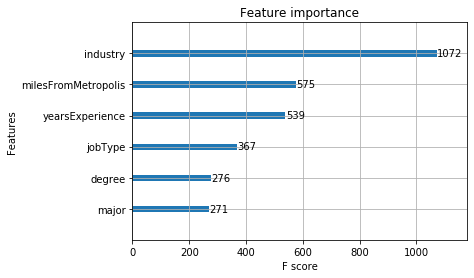

In [149]:
xg.plot_importance(xgb3)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
CHOOSE Decision Trees model and improve on it

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [36]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [37]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [38]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [39]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [40]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [41]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data